# Error Analysis of Transformer for Topic Classification

In this notebook, we will analyze the errors made by our fine-tuned Transformer model on a topic classification task using a dataset of news headlines and their associated news topic labels.

The model used is the `xtremedistil-l12-h384-uncased` model found in the [HuggingFace Model Hub](https://huggingface.co/microsoft/xtremedistil-l12-h384-uncased).

In [21]:
# To allow importing modules from src
import sys
import os

# Get the absolute path of the 'src' directory
src_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add 'src' directory to the Python path
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from sklearn.metrics import classification_report

from transformers import AutoModelForSequenceClassification, AutoTokenizer, PreTrainedModel

from helpers import TopicDataset, TOPIC_TO_ID, ID_TO_TOPIC, load_model, PlattScaling

### Load the pre-trained model and tokenizer

In [23]:
BATCH_SIZE = 100
MODEL_NAME = 'microsoft/xtremedistil-l12-h384-uncased'
TIME = '2023-05-16 20-44-08'

base_name = os.path.basename(MODEL_NAME)
model_path = f'../../models/{base_name}-topic {TIME}.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding="max_length", truncation=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2, id2label=ID_TO_TOPIC, label2id=TOPIC_TO_ID
)

model = load_model(model, model_path, device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/xtremedistil-l12-h384-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Load and preprocess the dataset

In [25]:
def collate_batch(batch, tokenizer, max_length=25):
    """Process a batch of data to its proper form."""
    # Feature should be batch_size * num_words * num_vocabs
    features, labels = zip(*batch)
    features = tokenizer(features, add_special_tokens=True, max_length=max_length, 
                         padding="max_length", truncation=True, return_tensors="pt")
    labels = torch.stack(labels)
    return features, labels

In [26]:
# Read the dataset
val_data = TopicDataset('../../data/fixed-data/topic-val.csv')
test_data = TopicDataset('../../data/fixed-data/topic-test.csv')

val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False,
                        collate_fn=lambda x: collate_batch(x, tokenizer))
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False,
                         collate_fn=lambda x: collate_batch(x, tokenizer))

### Evaluate the model

In [27]:
def get_predictions(model, data_loader, device='cpu'):
    """Get predictions from the model and targets on the data_loader."""
    model.eval()
    all_outputs = []
    all_targets = []
    for features, target in data_loader:
        features = features.to(device=device)
        target = target.to(device=device)
        
        # One-hot encode targets
        if isinstance(model, PreTrainedModel):
            output = model(**features, labels=target).logits
        else:
            output = model(features)
            if isinstance(output, tuple):
                output = output[0]
                
        target = torch.nn.functional.one_hot(target, num_classes=2)
        output = output.detach().to('cpu')
        target = target.detach().to('cpu')
        all_outputs.append(output)
        all_targets.append(target)

    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    return all_outputs, all_targets

# WARNING: This may take some time to run
output, target = get_predictions(model, val_loader, device=device) 

In [28]:
def _classification_report(output, target):
    probs = torch.nn.functional.softmax(output, dim=1)
    preds = probs.argmax(dim=1)
    target = target.argmax(dim=1)
    report = classification_report(target, preds, output_dict=True, 
                                   target_names=ID_TO_TOPIC.values())
    report = pd.DataFrame(report)
    cols = ['Economics', 'Other', 'weighted avg']
    rows = ['precision', 'recall', 'f1-score']
    return report.loc[rows, cols].transpose()


def _baseline_accuracy(target):
    counter = target.sum(axis=0)
    counter = (counter/ counter.sum())
    
    baseline_acc = pd.DataFrame(counter, columns=['baseline accuracy'], index=ID_TO_TOPIC.values())
    baseline_acc.loc['weighted avg'] = counter.max().item()
    return baseline_acc


def compute_metrics(output, target):
    cls_report = _classification_report(output, target)
    baseline_accuracy = _baseline_accuracy(target)
    cls_report = pd.concat([baseline_accuracy, cls_report], axis=1)
    return cls_report

cls_report = compute_metrics(output, target)
cls_report

,baseline accuracy,precision,recall,f1-score
Other,0.626817,0.959674,0.946751,0.953169
Economics,0.373183,0.912539,0.933179,0.922743
weighted avg,0.626817,0.942084,0.941686,0.941815


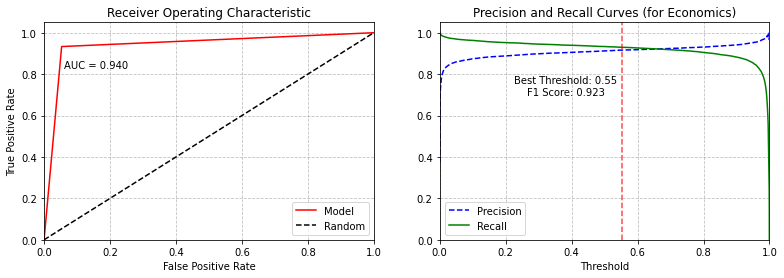

In [29]:
# Plot ROC curve and compute AUC
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot_roc_curve(ax, output, target):
    probs = torch.nn.functional.softmax(output, dim=1)
    preds = probs.argmax(dim=1)
    target = target.argmax(dim=1)
    fpr, tpr, _ = roc_curve(target, preds)
    auc_score = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, 'r-', label='Model')
    ax.plot([0, 1], [0, 1], 'k--', label='Random')  # random predictions curve
    ax.grid(visible=True, which='major', color='grey', linestyle='--', alpha=0.5)
    ax.legend(loc="lower right")
    ax.set_title(f'Receiver Operating Characteristic')
    ax.text(0.06, 0.83, f'AUC = {auc_score:.3f}', fontsize=10)
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')


def plot_precision_recall_curve(ax, output, target):
    probs = torch.nn.functional.softmax(output, dim=1)[:, 1]
    target = target[:, 1]
    precision, recall, thresholds = precision_recall_curve(target, probs)
    f1 = 2 * (precision * recall) / (precision + recall)

    ax.plot(thresholds, precision[:-1], "b--", label="Precision")
    ax.plot(thresholds, recall[:-1], "g-", label="Recall")
    ax.grid(visible=True, which='major', color='grey', linestyle='--', alpha=0.5)
    ax.set_title("Precision and Recall Curves (for Economics)")
    ax.legend(loc="lower left")
    
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 1.05])
    ax.set_xlabel("Threshold")
    
    # plot the best threshold
    best_threshold = thresholds[np.argmax(f1)]
    ax.vlines(best_threshold, 0, 1.05, color='red', linestyle='--', alpha=0.7)
    ax.text(best_threshold - 0.17, 0.70, 
            f'Best Threshold: {best_threshold:.2f}\nF1 Score: {np.max(f1):.3f}', 
            fontsize=10, horizontalalignment='center')

fig, axes = plt.subplots(1, 2, figsize=(13, 4))
plot_roc_curve(axes[0], output, target)
plot_precision_recall_curve(axes[1], output, target)
plt.show()

### Analyze misclassified samples

In [30]:
def get_missclassified_indices(output, target):
    output = torch.nn.functional.softmax(output, dim=1)
    miscls_data = (output.argmax(dim=1) != target.argmax(dim=1))
    misclassified_indices = miscls_data.nonzero(as_tuple=True)[0]
    return misclassified_indices.numpy()


def dataset_to_df(dataset):
    df = pd.DataFrame(tuple(dataset), columns=['Headlines', 'Topic'])
    df['Topic'] = df['Topic'].apply(lambda x: x.item())
    return df

def create_missclassification_df(dataset, output, target):
    df = dataset_to_df(dataset)
    misclassified_indices = get_missclassified_indices(output, target)
    df = df.iloc[misclassified_indices].copy()

    df['Predicted'] = output.argmax(dim=1)[misclassified_indices].numpy()
    df['Topic'] = df['Topic'].map(ID_TO_TOPIC)
    df['Predicted'] = df['Predicted'].map(ID_TO_TOPIC)
    return df

In [31]:
def label_dataset_and_convert_to_df(dataset, output):
    df = _dataset_to_df(dataset)
    df['Predicted Topic'] = _map_prediction_to_labels(output)
    return df

def _dataset_to_df(dataset):
    df = pd.DataFrame(tuple(dataset), columns=['Headlines', 'Topic'])
    df['Topic'] = df['Topic'].apply(lambda x: x.item())
    df['Topic'] = df['Topic'].map(ID_TO_TOPIC)
    return df

def _map_prediction_to_labels(output):
    output = output.argmax(dim=1)
    output = pd.Series(output.numpy()).map(ID_TO_TOPIC)
    return output

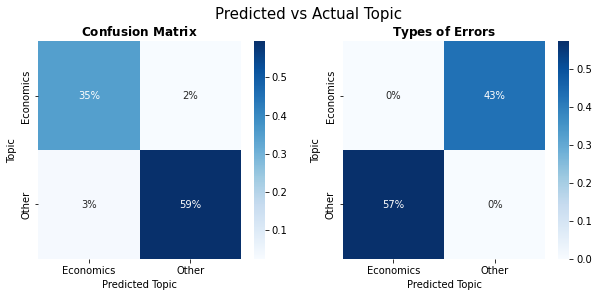

In [32]:
val_df = label_dataset_and_convert_to_df(val_data, output)
conf_mat = pd.crosstab(val_df['Topic'], val_df['Predicted Topic'])
error_rates = conf_mat.copy()
for i in range(len(error_rates)):
    error_rates.iloc[i,i] = 0

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(conf_mat / conf_mat.sum().sum(), ax=axes[0], annot=True, 
            fmt='.0%', cmap='Blues')
axes[0].set_title('$\\bf{Confusion\,\,Matrix}$')

sns.heatmap(error_rates / error_rates.sum().sum(), ax=axes[1], annot=True, 
            fmt='.0%', cmap='Blues')
axes[1].set_title('$\\bf{Types\,\,of\,\,Errors}$')

plt.suptitle('Predicted vs Actual Topic', fontsize=15, y=1)
plt.show()

In [33]:
disagree_df = val_df[val_df['Topic'] != val_df['Predicted Topic']]
econ_other = disagree_df[disagree_df['Topic'] == 'Economics'].sample(6)
other_econ = disagree_df[disagree_df['Topic'] == 'Other'].sample(6)

print('\033[1m' + 'Topic: Economics, Predicted: Other' + '\033[0m')
for row in econ_other.values.tolist():
    print(f'  "{row[0]}"')

print('\n\033[1m' + 'Topic: Other, Predicted: Economics' + '\033[0m')
for row in other_econ.values.tolist():
    print(f'  "{row[0]}"')

Topic: Economics, Predicted: Other
  "we re not cyprus number two, latvia says"
  "windows 10 security blunder as google reveals microsofts patch tuesday fix failure"
  "soon you might not be able to afford these 10 foods"
  "ea access for pc is coming soon to steam"
  "is there anyone out there who didn t lend money to three arrows"
  "nsa warning on location tracking stop using your phone"

Topic: Other, Predicted: Economics
  "space station crew told to cut back on food"
  "no rthern trust bank of florida has full"
  "house defeats fda proposal"
  "stock inf0 yep"
  "walmart halts ammunition sales for assault-style rifles kroger calls for gun safety"
  "pope s french visit leaves debt"


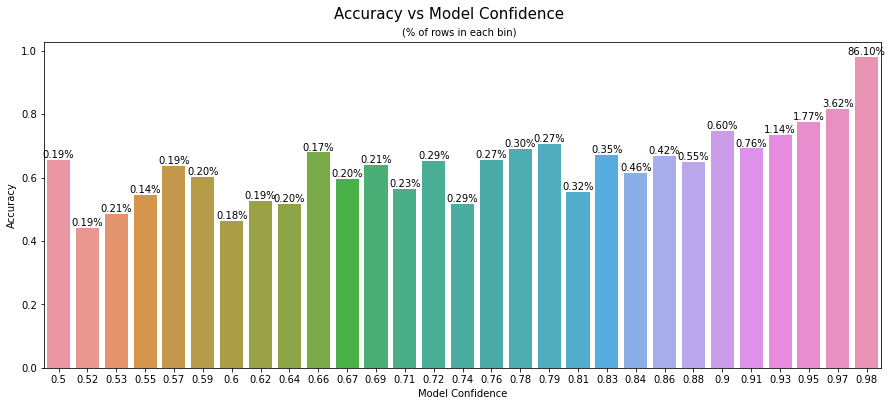

In [34]:
def plot_accuracy_vs_model_confidence(probs, target, title=None):
    confidence = np.max(probs, axis=1)
    target_labels = np.argmax(target.numpy(), axis=1)
    correct_preds = np.where(np.argmax(probs, axis=1) == target_labels, 1, 0)

    # Calculate error rate per confidence interval
    confidence_intervals = np.linspace(0.5, 1, 30)
    accuracy = []
    row_percentage = []
    for i in range(len(confidence_intervals) - 1):
        mask = (confidence >= confidence_intervals[i]) & (confidence < confidence_intervals[i + 1])
        if np.sum(mask) > 0:
            accuracy.append(np.mean(correct_preds[mask]))
            row_percentage.append(np.sum(mask) / len(confidence) * 100)
        else:
            accuracy.append(np.nan)
            row_percentage.append(0)

    # Plot error rate vs. model confidence
    plt.figure(figsize=(15, 6))
    ax = sns.barplot(x=np.round(confidence_intervals[:-1], 2), y=accuracy)

    # Annotate bars with the percentage of rows in each bin
    for i, p in enumerate(ax.patches):
        ax.annotate(
            f"{row_percentage[i]:.2f}%",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha="center",
            va="bottom",
            fontsize=10,
        )

    plt.xlabel("Model Confidence")
    plt.ylabel("Accuracy")
    if title:
        plt.suptitle(title, fontsize=15, y=0.96)
    else:
        plt.suptitle("Accuracy vs Model Confidence", fontsize=15, y=0.96)
    plt.title("(% of rows in each bin)  ", fontsize=10)
    plt.show()
    
probs = torch.softmax(output, dim=1).numpy()
plot_accuracy_vs_model_confidence(probs, target)

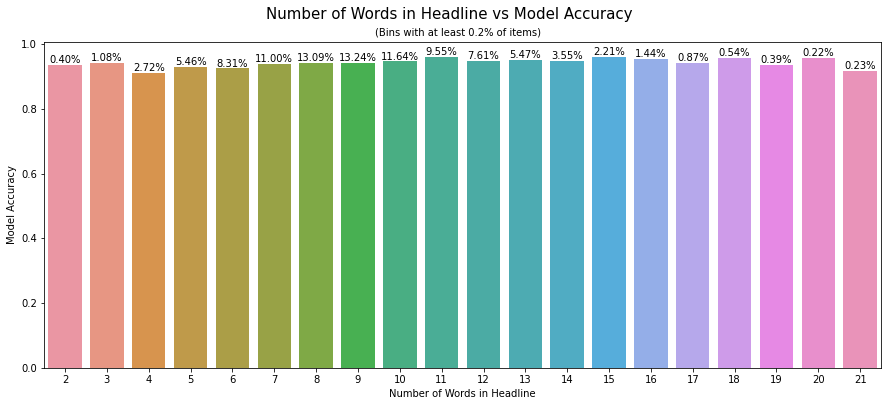

In [35]:
probs = torch.softmax(output, dim=1).numpy()
confidence = np.max(probs, axis=1)
target_labels = np.argmax(target.numpy(), axis=1)
correct_preds = np.where(np.argmax(probs, axis=1) == target_labels, 1, 0)

df = dataset_to_df(val_data)
df['word_count'] = df['Headlines'].apply(lambda x: len(x.split()))
df['is_correct'] = (correct_preds).astype(int)

word_count_accuracy = df.groupby('word_count')['is_correct'].mean().reset_index()
# Calculate the percentage of rows for each word count bin
word_count_percentage = df.groupby('word_count')['is_correct'].count().reset_index()
word_count_percentage['percentage'] = (word_count_percentage['is_correct'] / df.shape[0]) * 100

# Merge accuracy and percentage data
word_count_data = pd.merge(word_count_accuracy, word_count_percentage, on='word_count', suffixes=('_accuracy', '_count'))
word_count_data_filtered = word_count_data[word_count_data['percentage'] >= 0.2]

# Create the bar plot
plt.figure(figsize=(15, 6))
ax = sns.barplot(x='word_count', y='is_correct_accuracy', data=word_count_data_filtered)
# Add annotations to the plot
for i, p in enumerate(ax.patches):
    percentage = word_count_data_filtered.iloc[i]['percentage']
    ax.annotate(
        f"{percentage:.2f}%",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom',
        fontsize=10,
    )

plt.xlabel('Number of Words in Headline')
plt.ylabel('Model Accuracy')
plt.suptitle('Number of Words in Headline vs Model Accuracy', fontsize=15, y=0.96)
plt.title('(Bins with at least 0.2% of items)   ', fontsize=10)
plt.show()

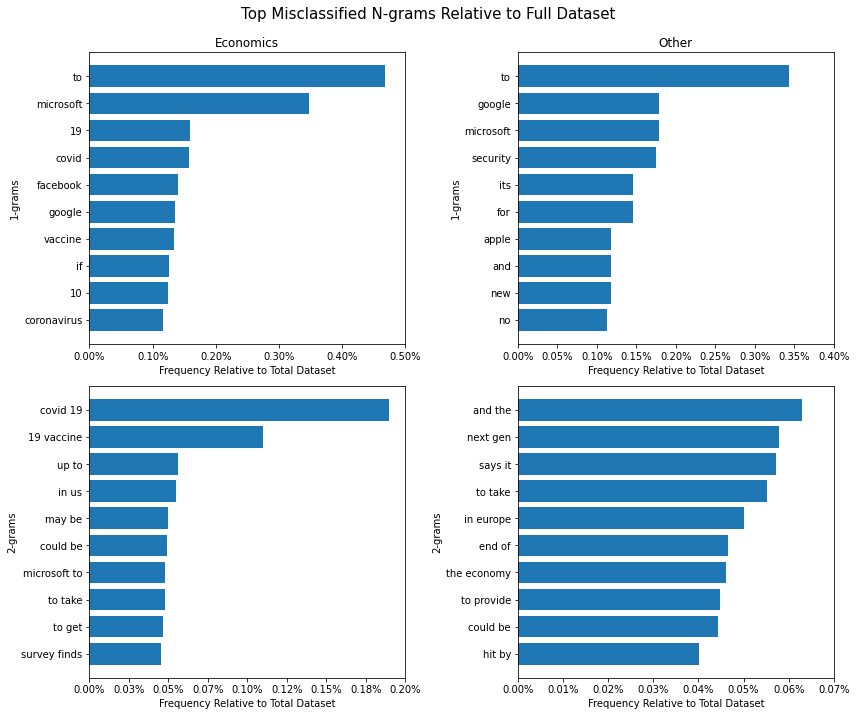

In [36]:
# Plot the distribution of word counts of misclassified samples vs. all samples for each Topic
from sklearn.feature_extraction.text import CountVectorizer


def get_ngrams(corpus, ngrams=1, relative=False):
    """Get all n-grams from a corpus of text.
    
    Args:
        corpus: A list of strings representing the text documents.
        ngrams: The size of the n-grams to be extracted (default: 1).
        relative: If True, returns relative frequencies (default: False).
    
    Returns:
        A tuple containing two lists: n-gram words and their corresponding frequencies.
    """
    vec = CountVectorizer(ngram_range=(ngrams, ngrams)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    words, frequencies = zip(*words_freq)
    if relative:
        frequencies = frequencies / np.sum(frequencies)
    return dict(zip(words, frequencies))


def plot_top_ngrams_relative(ax, corpus, total_counts, ngrams=1, top_k=10):
    """ Plot the top k n-grams relative to the total dataset for a given corpus.
    
    I.e. if 'bull' is 0.2% of the total dataset and 0.6% of the corpus, then the relative
    frequency of 'bull' is 0.6 - 0.2 = 0.4 %.
    
    Args:
        ax: A matplotlib axes object for plotting.
        corpus: A list of strings representing the text documents.
        total_counts: A dictionary containing the total counts of n-grams for all topics.
        ngrams: The size of the n-grams to be extracted (default: 1).
        top_k: The number of top n-grams to display (default: 10).
    """
    word_freq = get_ngrams(corpus, ngrams=ngrams, relative=True)
    relative_word_freq = [(w, f - total_counts[w]) for w, f in word_freq.items()]
    words_freq = sorted(relative_word_freq, key=lambda x: x[1], reverse=True)[:top_k]
    words, relative_frequencies = zip(*words_freq)

    ax.barh(words, relative_frequencies)
    ax.invert_yaxis()
    ax.set_xlabel('Frequency Relative to Total Dataset')
    ax.set_ylabel(f'{ngrams}-grams')
    # Set x-axis to percentage
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(['{:,.2%}'.format(x) for x in xticks])

total_1ngrams = get_ngrams(df['Headlines'], ngrams=1, relative=True)
total_2ngrams = get_ngrams(df['Headlines'], ngrams=2, relative=True)

unique_topics = ['Economics', 'Other']
fig, axes = plt.subplots(2, len(unique_topics), figsize=(6 * len(unique_topics), 10))

for col, topic in enumerate(unique_topics):
    label_is_topic_x = df['Topic'] == TOPIC_TO_ID[topic]
    model_is_not_correct = df['is_correct'] == 0
    missclassified_headlines = df[label_is_topic_x & model_is_not_correct]['Headlines']
    axes[0, col].set_title(topic)
    plot_top_ngrams_relative(axes[0, col], missclassified_headlines, total_counts=total_1ngrams, ngrams=1)
    plot_top_ngrams_relative(axes[1, col], missclassified_headlines, total_counts=total_2ngrams, ngrams=2)

fig.suptitle('Top Misclassified N-grams Relative to Full Dataset', fontsize=15, y=0.99)
plt.tight_layout()
plt.show()

### Test Set Evaluation

Since the model achieved a validation F1 of 0.92, and no big problems were found in the error analysis, we will evaluate the model on the test set. This means that no further fine-tuning will be performed.

In [37]:
val_output, val_target = output, target  # Rename for clarity
test_output, test_target = get_predictions(model, test_loader, device=device)
print(compute_metrics(test_output, test_target))

              baseline accuracy  precision    recall  f1-score
Other                  0.626624   0.960993  0.949397  0.955160
Economics              0.373376   0.916760  0.935326  0.925950
weighted avg           0.626624   0.944477  0.944143  0.944253


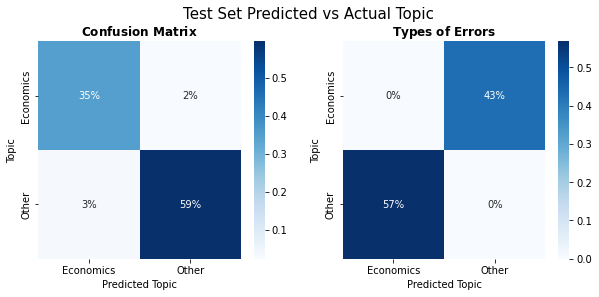

In [38]:
test_df = label_dataset_and_convert_to_df(test_data, test_output)
conf_mat = pd.crosstab(test_df['Topic'], test_df['Predicted Topic'])
error_rates = conf_mat.copy()
for i in range(len(error_rates)):
    error_rates.iloc[i,i] = 0

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(conf_mat / conf_mat.sum().sum(), ax=axes[0], annot=True, 
            fmt='.0%', cmap='Blues')
axes[0].set_title('$\\bf{Confusion\,\,Matrix}$')

sns.heatmap(error_rates / error_rates.sum().sum(), ax=axes[1], annot=True, 
            fmt='.0%', cmap='Blues')
axes[1].set_title('$\\bf{Types\,\,of\,\,Errors}$')

plt.suptitle('Test Set Predicted vs Actual Topic', fontsize=15, y=1)
plt.show()

## Key Findings

- The model achieves an F1-score of ~0.92 on the validation and the test sets.
- Adjusting the threshold would not significantly increase the F1-score.
- The type of errors made is balanced between the two categories.
- On manual inspection of misclassified samples, we found that the model prediction was correct in many cases, and the labels were incorrect.
- The model is more likely to misclassify samples involving tech companies and `covid 19`.

Overall, the model performs well enough on the both validation and test set to be used in real-world applications.

### Earlier Findings
<span style="color: #999999">*This section contains the findings from a model trained on an earlier 
version of the dataset.*</span>

- The model struggles with classifying to many topics as `Economics`.
    - Most of the misclassified samples are challenging to predict, even for humans, indicating 
that the topic of these sentences are ambiguous.
- There is no correlation between the length of a headline and prediction accuracy.
- A noteworthy pattern is that `sharing economy` is the n-gram most frequently misclassified as 
`Economics`.
    - Also the amount of numbers classified as `Other` is also an interesting pattern.

To improve the model, we should try to improve training data labels.

## Calibrating Model Prediction Probabilities

We're going to test Platt scaling with fitted logistic regression models to calibrate the model outputs. We will fit the model on the validation set and evaluate it on the test set.

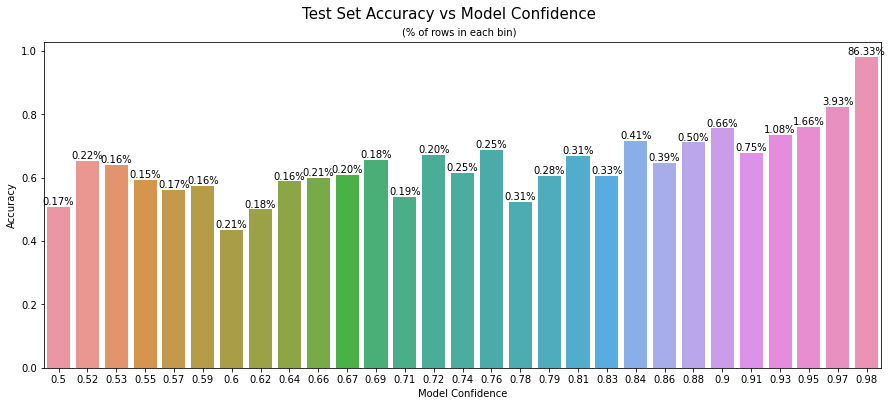

In [39]:
# First, let's evaluate the calibration of the model on the test set
test_probs = torch.softmax(test_output, dim=1).cpu().numpy()
plot_accuracy_vs_model_confidence(
    test_probs, test_target, title='Test Set Accuracy vs Model Confidence'
)

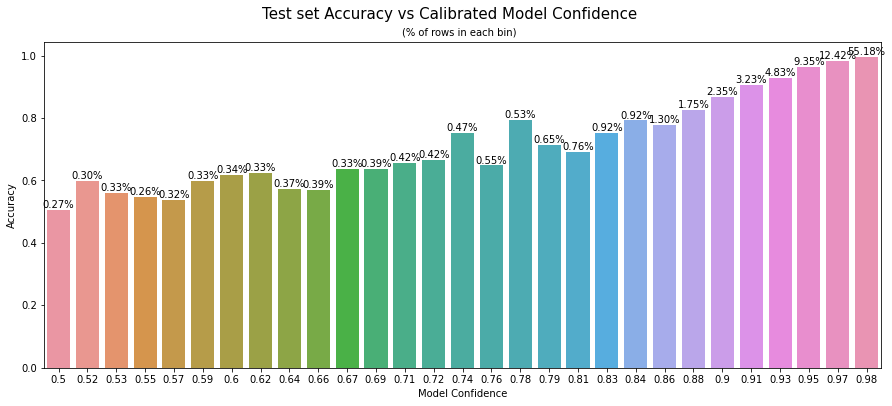

In [40]:
platt_scaler = PlattScaling()
platt_scaler.fit(val_output, val_target)
calibrated_probs = platt_scaler.transform(test_output).numpy()
plot_accuracy_vs_model_confidence(
    calibrated_probs, test_target, title='Test set Accuracy vs Calibrated Model Confidence'
)

Platt scaling improves the model's calibration significantly. A version trained on both validation and test set will be used in the final prediction pipeline.